In [1]:
import numpy as np
import cv2
import imutils
import pandas as pd

from imutils import paths
from matplotlib import pyplot as plt

## Tracking a Sheet of Paper to Calculate Distance

A sheet of white paper is used instead of an iPhone because it's more pragmatic, larger, and more consistent. In other words, if it doesn't work for a sheet of paper, it likely won't work for an iPhone.

The approach:
- set a piece of paper 2 feet away from the webcam & snap a picture
- use the known distance, known width of the piece of paper, and pixel width to calculate `focal length` --> `focal_length = (pixel_width * KNOWN_DISTANCE) / KNOWN_WIDTH`
- `focal_length` is used to calculate distance as the object moves closer or farther away, where `distance = (KNOWN_WIDTH * focal_length) / pixel_width`
- `pixel_width` is found by using contours, detected via Haar features, to estimate a polygon with between 4 to 6 points

Images of me holding a piece of paper were taken 2, 4, 6, & 9 feet away from the webcam & this distance was confirmed by using tape measure. 

The formulas for calculating `distance` & `focal_length` can be found [here](https://pyimagesearch.com/2015/01/19/find-distance-camera-objectmarker-using-python-opencv/).

In [2]:
KNOWN_DISTANCE = 24.0
KNOWN_WIDTH = 8.5

In [3]:
def find_markers_v2(image):
    """
    Convert an image to grayscale & draw contours that 
    reflect a 3-6 point polygon (approximation of a rectangle).
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 35, 125)
    
    contours = cv2.findContours(
        edged.copy(),
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE
    )
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    final_contours = []
    
    for contour in contours:
        x1, y1 = contour[0][0]
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.01 * peri, True)
        
        if len(approx) >= 3 and len(approx) <= 6:
            final_contours.append(contour)
            
    cv2.drawContours(image, final_contours, -1, (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()

The goal is to identify the contours in the images, stitch a rectangle to represent the piece of paper, and use the rectangle's pixel width to figure out distance.

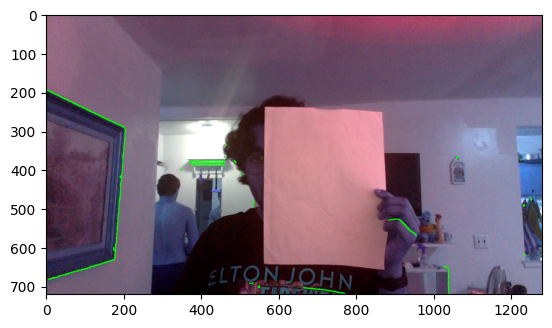

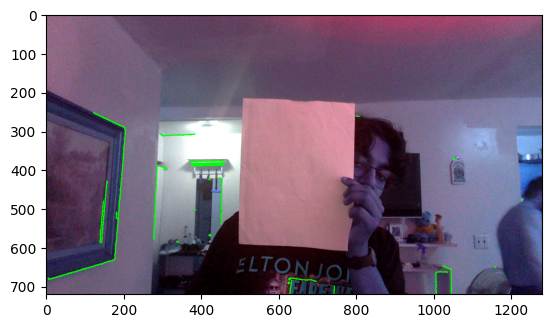

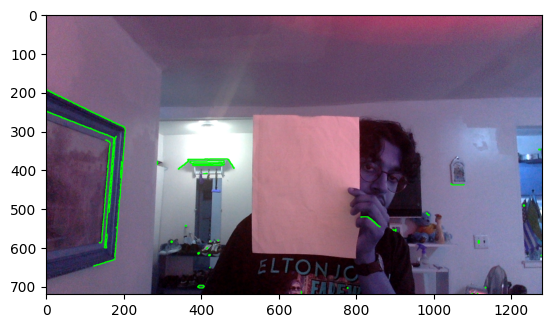

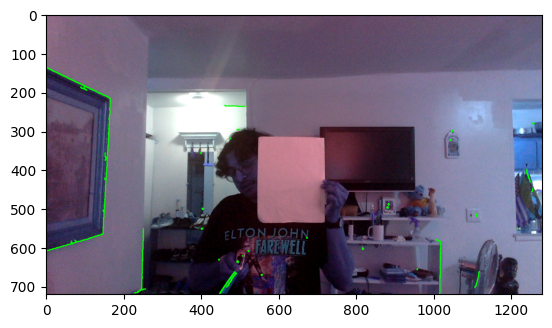

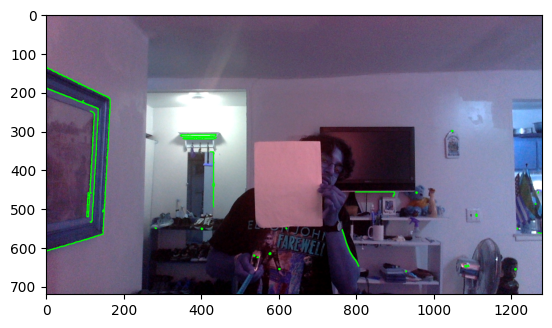

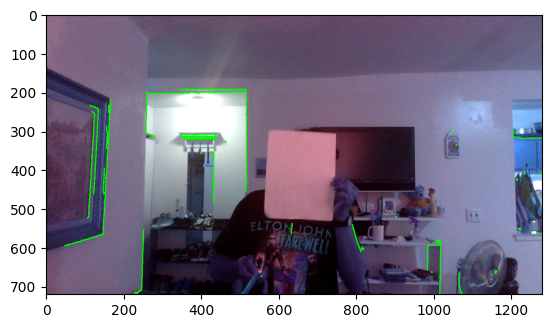

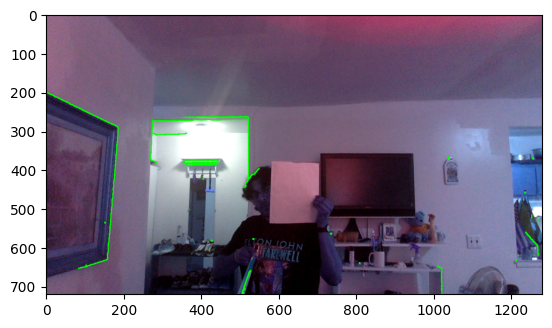

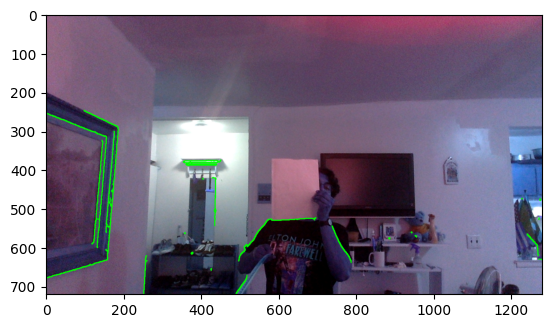

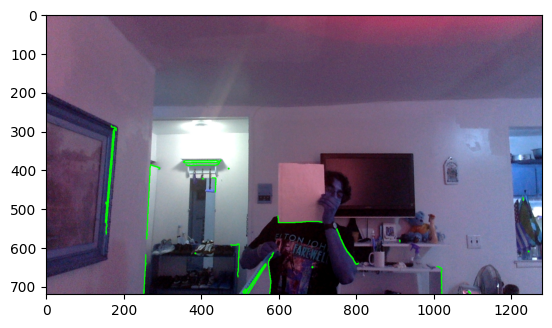

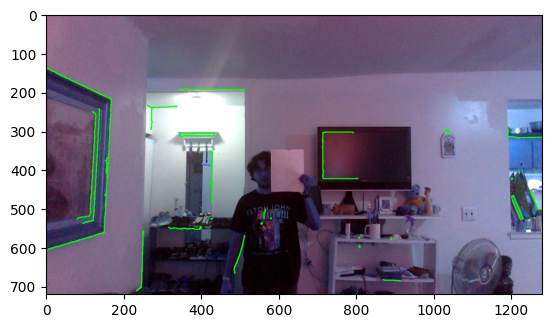

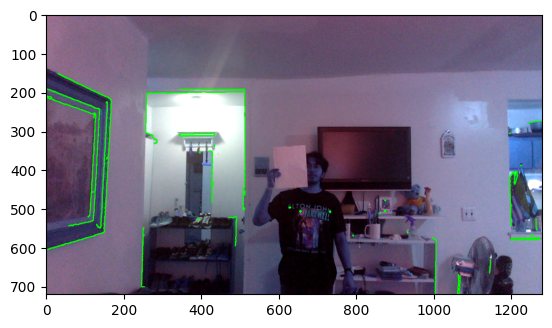

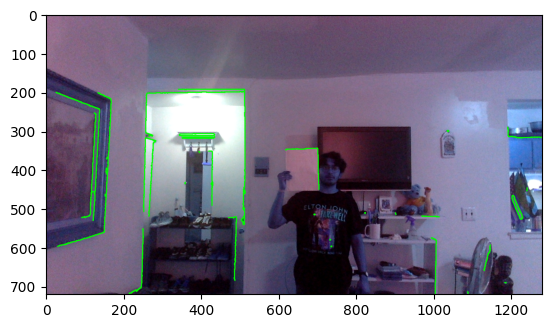

In [7]:
reference_images = []
for image_path in sorted(paths.list_images("images")):
    if ".ipynb" not in image_path:
        img = cv2.imread(image_path)
        find_markers_v2(img)

## Pause for a second...

Strange. Not a single rectangle in any of the pictures from 2 feet to 9 feet.
Because a hand is around the piece of paper, this prevents the shape from being assembled via contours.

This simple experiment strongly rejects the idea of using the webcam to track the iPhone as an option, for the following reasons:
- high potential for false positives (e.g. wrong, highlighted contours in the background)
- low accuracy of using Haar features to detect edges and stitch together a rectangle
- low availability of other off the shelf models to recognize a piece of paper or iPhone (especially amongst the false positives)
- poor pixel resolution of iPhone screen 

Now, detecting a piece of paper can be improved upon in other ways. For instance:
- using a deep learning model (issue here is latency if assuming high RPS)
- sending a printout of a QR code & asking the user to hold up an easily trackable, larger object
- using colors in tandem with Haar features

The main issue here (besides latency), is poor UX. And, latency is definitely an issue if training/using an off-the-shelf deep learning model to identify the sheet of paper or iPhone. Not an MVP-friendly approach.

However, the main approach is still valid. Calculate `focal_length` and calibrate it using a known distance & a known width. Then, use a changing `pixel_width` to estimate distance. This time, instead of using paper, facial detection will be used as faces are easier to recognize within the backdrop of a typical room. 

## Facial Detection
Faces will be calibrated the same way as the sheet of paper, starting at 2 feet away.
Then the distance will be estimated using pixel_face_width from pictures taken 2, 4, 6, & 9 feet away.

Some key formulas:
- `focal_length = (image_width * KNOWN_DISTANCE) / KNOWN_WIDTH`
- `distance = (KNOWN_WIDTH * focal_length) / pixel_width`

Face width will be calculated using multiple approaches:
- [Haar features](https://docs.opencv.org/3.4/d2/d99/tutorial_js_face_detection.html)
- [Dlib](http://dlib.net/face_recognition.py.html) - CNN based face detector
- [MTCNN](https://pypi.org/project/mtcnn/) - another CNN based face detector
- [DNN](https://docs.opencv.org/4.x/d0/dd4/tutorial_dnn_face.html) - deep neural network from OpenCV

The distance predictions from each method at each distance will be summarized in a dataframe below.

In [8]:
# import or install dependencies
from mtcnn.mtcnn import MTCNN
import dlib

haar_detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
detector = dlib.get_frontal_face_detector()
mtcnn_detector = MTCNN()

modelFile = "res10_300x300_ssd_iter_140000.caffemodel"
configFile = "deploy.prototxt"
dnn_net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

2023-02-22 17:58:18.408258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 17:58:40.798266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
def calculate_focal_length(known_distance, known_width, pixel_width):
    return (pixel_width * known_distance) / known_width

In [10]:
def calculate_distance(known_width, focal_length, pixel_width):
    return (known_width * focal_length) / pixel_width

In [11]:
def haar_face_width_from_image(image):
    face_width = 0
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = haar_detector.detectMultiScale(gray_image, 1.3, 5)

    for (x, y, h, w) in faces:
        face_width = w

    return face_width

In [12]:
def dlib_face_width_from_image(image):
    face_width = 0
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 1)
    
    widths = []
    for result in faces:
        x = result.left()
        x1 = result.right()
        width = abs(x - x1)
        widths.append(width)
        
    face_width = max(widths) if widths else 0
    return face_width

In [13]:
def mtcnn_face_width_from_image(image):
    faces = mtcnn_detector.detect_faces(img)
    face_width = 0
    
    widths = []
    for result in faces:
        _, _, width, _ = result['box']
        widths.append(width)
        
    face_width = max(widths) if widths else 0
    return face_width

In [14]:
def dnn_face_width_from_image(image):
    face_width = 0
    widths = []
    
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(
        cv2.resize(image, (300, 300)),
        1.0,
        (300, 300),
        (104.0, 117.0, 123.0)
    )
    dnn_net.setInput(blob)
    faces = dnn_net.forward()
    for i in range(faces.shape[2]):
        confidence = faces[0, 0, i, 2]
        if confidence > 0.5:
            box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, x1, y1) = box.astype("int")
            
            width = abs(x - x1)
            widths.append(width)
            
    face_width = max(widths) if widths else 0
    return face_width

In [15]:
# map each approach to the corresponding function

approaches = {
    'haar': haar_face_width_from_image,
    'dlib': dlib_face_width_from_image,
    'mtcnn': mtcnn_face_width_from_image,
    'dnn': dnn_face_width_from_image,
}

In [16]:
# calibrate focal length based on facial detection approach

reference_images = []
for image_path in sorted(paths.list_images("face_images")):
    if "2_FT" in image_path and ".ipynb" not in image_path:
        reference_images.append(image_path)

In [17]:
reference_images

['face_images/webcam_face_2_FT_1.png',
 'face_images/webcam_face_2_FT_2.png',
 'face_images/webcam_face_2_FT_3.png',
 'face_images/webcam_face_2_FT_4.png',
 'face_images/webcam_face_2_FT_5.png']

In [18]:
# calibration picture should be taken 2 feet away
KNOWN_DISTANCE = 24.0

# average facial width is 6 inches
KNOWN_WIDTH = 6

In [19]:
# get average focal length for calibrated pictures for each approach
# if focal length is 0, that means face wasn't detected in calibration approach
total_focal_length = 0.0
approach_to_focal_length = {}

# loop over each approach
for approach in approaches:
    total_focal_length = 0.0
    usable_images = 0
    
    # loop over images
    for image_path in reference_images:
        image = cv2.imread(image_path)
        face_pixel_width = approaches[approach](image)
        
        # can only calculate focal length if face_pixel_width is read
        if face_pixel_width:
            focal_length = calculate_focal_length(KNOWN_DISTANCE, KNOWN_WIDTH, face_pixel_width)
            total_focal_length += focal_length
            usable_images += 1
    
    average_focal_length = total_focal_length / len(reference_images)
    # map each approach's focal length 
    approach_to_focal_length[approach] = average_focal_length

1/1 [==============================] - 0s 30ms/step


In [21]:
approach_to_focal_length

{'haar': 1013.6, 'dlib': 862.4, 'mtcnn': 0.0, 'dnn': 793.6}

In [24]:
KNOWN_DISTANCE = 24.0
KNOWN_WIDTH = 6.5

# turn keys into list for consistency while reading from dict
approaches_list = list(approach_to_focal_length.keys())

# maps each image to the predicted distance
image_to_predictions = {}

for image_path in sorted(paths.list_images("face_images")):
    # don't read .ipynb files - they're old & corrupted
    if ".ipynb" in image_path:
        continue
        
    distance_predictions = []
    image = cv2.imread(image_path)
    print(image_path)
    
    for approach in approaches_list:
        focal_length = approach_to_focal_length[approach]
        face_width = approaches[approach](image)
        
        distance = 0.0
        
        # can only do distance calculation if face was detected
        if focal_length != 0.0 and face_width != 0.0:
            # calculate the distance based on pixel width of face
            distance = calculate_distance(KNOWN_WIDTH, focal_length, face_width) / 12.0
            
        distance_predictions.append(distance)
    
    # update predictions for each image
    image_to_predictions[image_path] = distance_predictions

face_images/webcam_face_2_FT_1.png
1/1 [==============================] - 0s 35ms/step
face_images/webcam_face_2_FT_2.png
1/1 [==============================] - 0s 31ms/step
face_images/webcam_face_2_FT_3.png
1/1 [==============================] - 0s 30ms/step
face_images/webcam_face_2_FT_4.png
1/1 [==============================] - 0s 30ms/step
face_images/webcam_face_2_FT_5.png
1/1 [==============================] - 0s 34ms/step
face_images/webcam_face_3_FT_1.png
1/1 [==============================] - 0s 32ms/step
face_images/webcam_face_3_FT_2.png
1/1 [==============================] - 0s 35ms/step
face_images/webcam_face_3_FT_3.png
1/1 [==============================] - 0s 31ms/step
face_images/webcam_face_3_FT_4.png
1/1 [==============================] - 0s 34ms/step
face_images/webcam_face_3_FT_5.png
1/1 [==============================] - 0s 29ms/step
face_images/webcam_face_4_FT_1.png
1/1 [==============================] - 0s 38ms/step
face_images/webcam_face_4_FT_2.png
1/1 [===

In [25]:
image_to_predictions

{'face_images/webcam_face_2_FT_1.png': [2.0718238993710694,
  2.0947683109118085,
  0.0,
  2.10718954248366],
 'face_images/webcam_face_2_FT_2.png': [2.0718238993710694,
  2.0947683109118085,
  0.0,
  2.1493333333333333],
 'face_images/webcam_face_2_FT_3.png': [2.0640350877192986,
  2.0947683109118085,
  0.0,
  2.1386401326699835],
 'face_images/webcam_face_2_FT_4.png': [2.2687327823691463,
  2.5114695340501787,
  0.0,
  2.227288428324698],
 'face_images/webcam_face_2_FT_5.png': [2.3975254730713247,
  2.0947683109118085,
  0.0,
  2.215807560137457],
 'face_images/webcam_face_3_FT_1.png': [3.0672253258845443,
  3.013763440860215,
  0.0,
  2.9645977011494256],
 'face_images/webcam_face_3_FT_2.png': [3.119507575757576,
  3.013763440860215,
  0.0,
  3.0060606060606063],
 'face_images/webcam_face_3_FT_3.png': [2.9517921146953405,
  3.013763440860215,
  0.0,
  2.9851851851851854],
 'face_images/webcam_face_3_FT_4.png': [3.1373333333333338,
  3.013763440860215,
  0.0,
  3.0060606060606063],
 

## Summary

The dataframe below contains the image & the predicted distance (in feet) based on each approach.
Dlib performs the best at distance, with the deep neural net & Haar features not too far behind. Both approaches are accurate til about 9 feet, until an error of +/- 1 foot begins to emerge.

Next steps:
* collect more data in a brighter setting
* examine other models to be used
* look at methods to augment webcam resolution artifically at greater distances

In [26]:
df = pd.DataFrame.from_dict(image_to_predictions, orient='index', columns=approaches_list)
df.head(50)

,haar,dlib,mtcnn,dnn
face_images/webcam_face_2_FT_1.png,2.071824,2.094768,0.0,2.107190
face_images/webcam_face_2_FT_2.png,2.071824,2.094768,0.0,2.149333
face_images/webcam_face_2_FT_3.png,2.064035,2.094768,0.0,2.138640
face_images/webcam_face_2_FT_4.png,2.268733,2.511470,0.0,2.227288
face_images/webcam_face_2_FT_5.png,2.397525,2.094768,0.0,2.215808
face_images/webcam_face_3_FT_1.png,3.067225,3.013763,0.0,2.964598
face_images/webcam_face_3_FT_2.png,3.119508,3.013763,0.0,3.006061
face_images/webcam_face_3_FT_3.png,2.951792,3.013763,0.0,2.985185
face_images/webcam_face_3_FT_4.png,3.137333,3.013763,0.0,3.006061
face_images/webcam_face_3_FT_5.png,3.067225,3.013763,0.0,2.924263
